## Data Extraction

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Set up Selenium options
options = Options()
options.add_argument("--start-maximized") 
options.add_argument("--disable-blink-features=AutomationControlled")

# Initialize WebDriver
driver = webdriver.Chrome(options=options)

checkin_date = '2025-12-08'
checkout_date = '2025-12-13'
url = f'https://www.booking.com/searchresults.en-gb.html?ss=Dubai&ssne=Dubai&ssne_untouched=Dubai&label=gen173nr-1BCAEoggI46AdIM1gEaCeIAQGYAQm4ARfIAQzYAQHoAQGIAgGoAgO4Ap6E9r8GwAIB0gIkZGVmZmJkZDItODllMy00MzYyLWI1NzYtYmYxMzBmOWYwNDE12AIF4AIB&sid=8fd4bdb03dcf8f26841898fcb103835a&aid=304142&lang=en-gb&sb=1&src_elem=sb&src=index&dest_id=-782831&dest_type=city&checkin={checkin_date}&checkout={checkout_date}&group_adults=1&no_rooms=1&group_children=0'

#  Open the url
driver.get(url)
time.sleep(2)  # wait for page to load

# Scroll to load more hotels (website behaviour)
driver.execute_script("window.scrollTo(0, document.body.scrollHeight,)")
time.sleep(5)

for i in range(28):
    print(f"Loading more hotels - iteration {i+1}")
    load_button = driver.find_element(By.CSS_SELECTOR, '.c82435a4b8.f581fde0b8 button')
    load_button.click()
    print(f"Load more button clicked")
    time.sleep(3)

# Scrape data 
hotels = driver.find_elements(By.CSS_SELECTOR, 'div[data-testid="property-card"]')
data = []

for hotel in hotels:
    name = hotel.find_element(By.CSS_SELECTOR, 'div[data-testid="title"]').text
    location = hotel.find_element(By.CSS_SELECTOR, 'span[data-testid="address"]').text
    price = hotel.find_element(By.CSS_SELECTOR, 'span[data-testid="price-and-discounted-price"]').text
    distance_from_center = hotel.find_element(By.CSS_SELECTOR, 'span[data-testid="distance"]').text 
    try:
        price_box = hotel.find_element(By.CSS_SELECTOR, 'div[data-testid="availability-rate-information"]')
        original_price = price_box.find_element(By.CSS_SELECTOR, '.f419a93f12 .abf093bdfe').text
    except NoSuchElementException:
        original_price = hotel.find_element(By.CSS_SELECTOR, 'span[data-testid="price-and-discounted-price"]').text
        
    try:
        rating_box = hotel.find_element(By.CSS_SELECTOR, 'div[data-testid="review-score"]')
        rating = rating_box.find_element(By.CLASS_NAME, 'ac4a7896c7').text
    except NoSuchElementException:
        rating_box = ""
    try:
        room_box = hotel.find_element(By.CSS_SELECTOR, 'div[data-testid="recommended-units"]')
        room_type = room_box.find_element(By.CSS_SELECTOR, 'h4').text
    except NoSuchElementException:
        room_box = ""

    data.append({
        "HotelName": name,
        "Location": location,
        "Price": price,
        "Rating": rating,
        "DistanceFromCenter": distance_from_center,
        "RoomType": room_type,
        "OriginalPrice": original_price
    })

df = pd.DataFrame(data)
df.to_csv("hotels_raw.csv", index=False)
df.head()

Loading more hotels - iteration 1
Load more button clicked
Loading more hotels - iteration 2
Load more button clicked
Loading more hotels - iteration 3
Load more button clicked
Loading more hotels - iteration 4
Load more button clicked
Loading more hotels - iteration 5
Load more button clicked
Loading more hotels - iteration 6
Load more button clicked
Loading more hotels - iteration 7
Load more button clicked
Loading more hotels - iteration 8
Load more button clicked
Loading more hotels - iteration 9
Load more button clicked
Loading more hotels - iteration 10
Load more button clicked
Loading more hotels - iteration 11
Load more button clicked
Loading more hotels - iteration 12
Load more button clicked
Loading more hotels - iteration 13
Load more button clicked
Loading more hotels - iteration 14
Load more button clicked
Loading more hotels - iteration 15
Load more button clicked
Loading more hotels - iteration 16
Load more button clicked
Loading more hotels - iteration 17
Load more butt

,HotelName,Location,Price,Rating,DistanceFromCenter,RoomType,OriginalPrice
0,Nikki Beach Resort & Spa Dubai,"Beach & Coast, Dubai","CAD 2,584",Scored 9.2,5.9 km from centre,Covet King Room,"CAD 3,692"
1,Atana Hotel,"Al Barsha, Dubai",CAD 473,Scored 8.5,14.1 km from centre,Standard Twin Room,CAD 473
2,TRYP by Wyndham Dubai,"Barsha Heights (Tecom) , Dubai",CAD 951,Scored 8.7,14.7 km from centre,Tryp Room,CAD 951
3,Golden Tulip Media Hotel,"Barsha Heights (Tecom) , Dubai",CAD 642,Scored 8.5,14.2 km from centre,Standard Room (Free transfers to the beach and...,CAD 642
4,Grand Mercure Dubai City,"Garhoud, Dubai",CAD 589,Scored 8.3,9.5 km from centre,Deluxe Twin Room - DXB Free Airport Drop-Off T...,CAD 589


## Data Cleaning & Preparation

In [4]:
# Clean the HotelName, RoomType column for any trailing spaces
df["HotelName"] = df["HotelName"].str.strip()
df["RoomType"] = df["RoomType"].str.strip()

# Remove Dubai from the Location column
df["Location"] = df["Location"].str.replace(", Dubai", "", regex = False).str.strip()

# Convert the Price column to numeric and remove "CAD"
df["Price"] = df["Price"].str.replace("CAD", "", regex = False).str.strip()
df["Price"] = df["Price"].str.replace(",", "", regex = False).str.strip().astype(float)

# Convert the Rating column to numeric and remove "Scored"
df["Rating"] = df["Rating"].str.replace("Scored", "", regex = False).str.strip().astype(float)

# Convert the OriginalPrice column to numeric and remove "CAD"
df["OriginalPrice"] = df["OriginalPrice"].str.replace("CAD", "", regex = False).str.strip()
df["OriginalPrice"] = df["OriginalPrice"].str.replace(",", "", regex = False).str.strip().astype(float)

# Convert the Distance From Centre column
import re
def clean_distance(val):
    if pd.isnull(val):
        return np.nan
    elif 'in the city centre' in val.lower():
        return 0.0
    else:
        match = re.search(r'(\d+\.?\d*)', val)
        return float(match.group(1)) if match else np.nan

df['DistanceFromCenter'] = df['DistanceFromCenter'].apply(clean_distance)

# Add new column PricePerNight
df["PricePerNight"] = df["Price"]/4

# Add new column Discount
df["Discount"] = round(((df["OriginalPrice"] - df["Price"])/df["OriginalPrice"])*100,2)

# Save the cleaned data to the .csv file
df.to_csv("hotels_cleaned.csv", index=False)
df.head()

,HotelName,Location,Price,Rating,DistanceFromCenter,RoomType,OriginalPrice,PricePerNight,Discount
0,Nikki Beach Resort & Spa Dubai,Beach & Coast,2584.0,9.2,5.9,Covet King Room,3692.0,646.00,30.01
1,Atana Hotel,Al Barsha,473.0,8.5,14.1,Standard Twin Room,473.0,118.25,0.00
2,TRYP by Wyndham Dubai,Barsha Heights (Tecom),951.0,8.7,14.7,Tryp Room,951.0,237.75,0.00
3,Golden Tulip Media Hotel,Barsha Heights (Tecom),642.0,8.5,14.2,Standard Room (Free transfers to the beach and...,642.0,160.50,0.00
4,Grand Mercure Dubai City,Garhoud,589.0,8.3,9.5,Deluxe Twin Room - DXB Free Airport Drop-Off T...,589.0,147.25,0.00


## Feature Engineering

In [6]:
# Room type custom column
import re

def extract_bed_info(room_type):
    if pd.isna(room_type): return 'Unknown'
    room_type = room_type.lower()
    if 'quad' in room_type or '4' in room_type:
        return 'Quadruple'
    elif 'triple' in room_type or '3' in room_type or 'three' in room_type:
        return 'Triple'
    elif 'double' in room_type or '2' in room_type or 'twin' in room_type or 'queen' in room_type or 'two' in room_type:
        return 'Double/Twin'
    elif 'single' in room_type or '1' in room_type or 'one' in room_type:
        return 'Single'
    elif 'family' in room_type or 'king' in room_type:
        return 'Family'
    elif 'suite' in room_type:
        return 'Suite'
    else:
        return 'Other'

df['RoomCategory'] = df['RoomType'].apply(extract_bed_info)

In [7]:
# Custom Rating Bucket column
df['RatingBucket'] = pd.cut(df['Rating'], bins=[0, 7, 8, 9, 10], labels=['Poor', 'Fair', 'Good', 'Excellent'])

In [8]:
# Custom Discount Bucket column
df['DiscountBucket'] = pd.cut(df['Discount'], bins=[-1, 0, 20, 40, 100], labels=['No Discount', 'Low', 'Medium', 'High'])

In [9]:
# Custom Location Group column
top_locations = df['Location'].value_counts().nlargest(5).index.tolist()
df['LocationGroup'] = df['Location'].apply(lambda x: x if x in top_locations else 'Other')

## Encoding Features

In [11]:
from sklearn.preprocessing import LabelEncoder

label_cols = ['RoomCategory', 'LocationGroup', 'RatingBucket', 'DiscountBucket']
le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col].astype(str))

df_encoded = pd.get_dummies(df, columns=['RoomCategory', 'LocationGroup', 'RatingBucket', 'DiscountBucket'], drop_first=True)

## Summary Stats & EDA

In [13]:
# Setting up basic style for visuals
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

print(df.describe())
print(df.info())
print(df.isnull().sum())

              Price      Rating  DistanceFromCenter  OriginalPrice  \
count    774.000000  774.000000          774.000000     774.000000   
mean    1427.617571    8.536047           27.206589    1477.583979   
std     1073.160870    0.848669           74.030048    1106.692879   
min       28.000000    1.000000            0.600000      28.000000   
25%      816.500000    8.200000            3.300000     844.750000   
50%     1150.000000    8.600000            9.500000    1176.500000   
75%     1634.750000    9.000000           17.400000    1682.000000   
max    13253.000000   10.000000          450.000000   13253.000000   

       PricePerNight    Discount  RoomCategory  RatingBucket  DiscountBucket  \
count     774.000000  774.000000    774.000000    774.000000      774.000000   
mean      356.904393    2.803773      2.041344      1.436693        2.786822   
std       268.290217    8.673343      1.583664      0.903062        0.616531   
min         7.000000    0.000000      0.000000   

### Distribution of Hotel Price Per Night

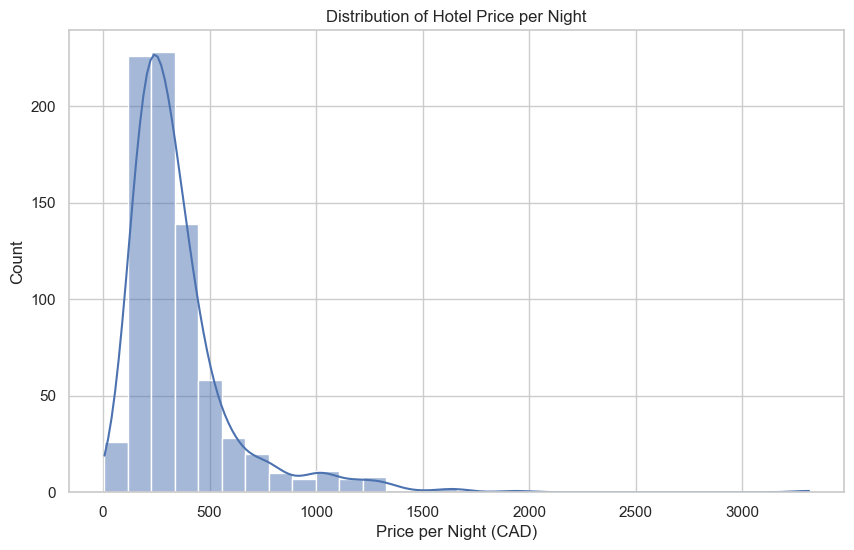

In [15]:
sns.histplot(df["PricePerNight"], kde=True, bins=30)
plt.title('Distribution of Hotel Price per Night')
plt.xlabel('Price per Night (CAD)')
plt.ylabel('Count')
plt.show()

### Count of Hotels by Room Category

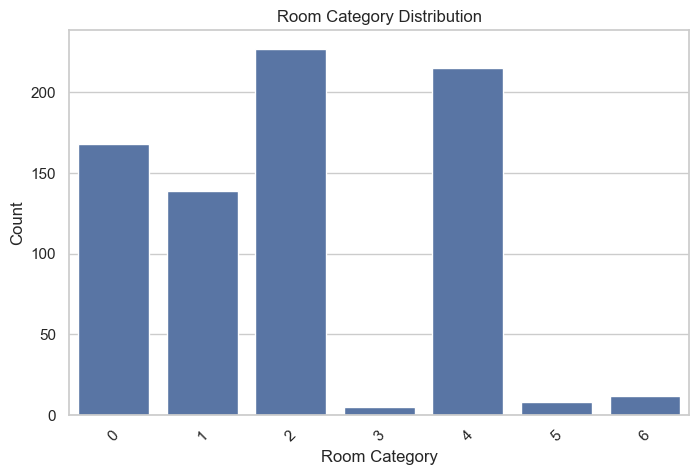

In [17]:
room_counts = df['RoomCategory'].value_counts().sort_values(ascending=False)
room_df = pd.DataFrame({'RoomCategory': room_counts.index, 'Count': room_counts.values})
plt.figure(figsize=(8,5))
sns.barplot(x='RoomCategory', y='Count', data=room_df)
plt.title('Room Category Distribution')
plt.xlabel('Room Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Average Price per Night by Location

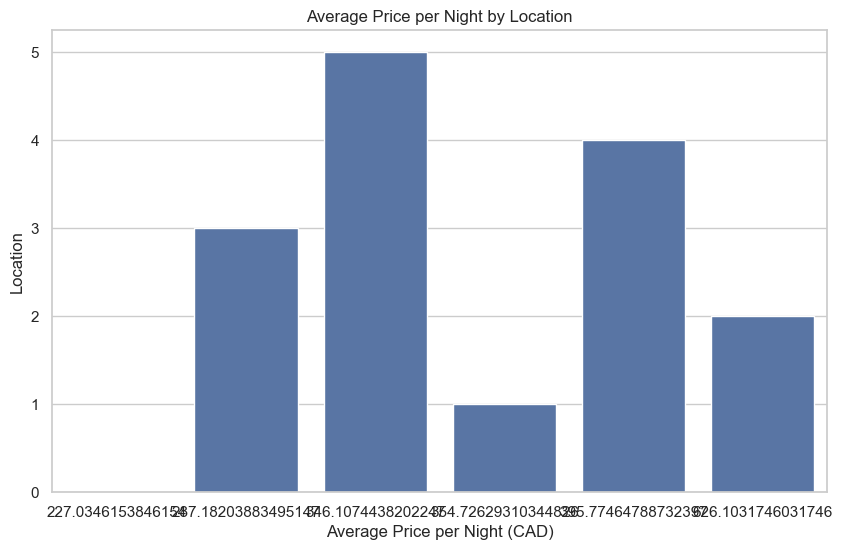

In [19]:
avg_price_location = df.groupby('LocationGroup')['PricePerNight'].mean().sort_values()
sns.barplot(x=avg_price_location.values, y=avg_price_location.index)
plt.title('Average Price per Night by Location')
plt.xlabel('Average Price per Night (CAD)')
plt.ylabel('Location')
plt.show()

### Rating Bucket Distribution

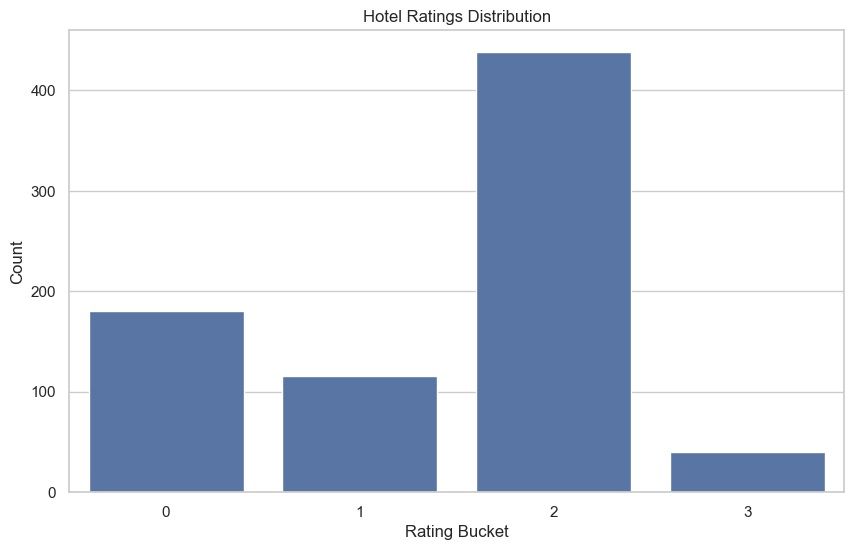

In [21]:
sns.countplot(x='RatingBucket', data=df)
plt.title('Hotel Ratings Distribution')
plt.xlabel('Rating Bucket')
plt.ylabel('Count')
plt.show()

### Price vs. Discount Bucket

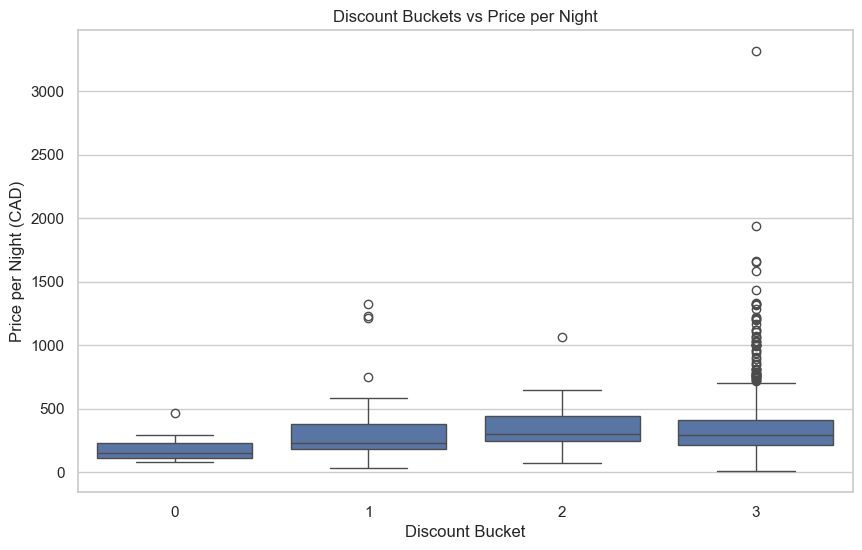

In [23]:
sns.boxplot(x='DiscountBucket', y='PricePerNight', data=df)
plt.title('Discount Buckets vs Price per Night')
plt.xlabel('Discount Bucket')
plt.ylabel('Price per Night (CAD)')
plt.show()

### Top 10 Most Common Room Types

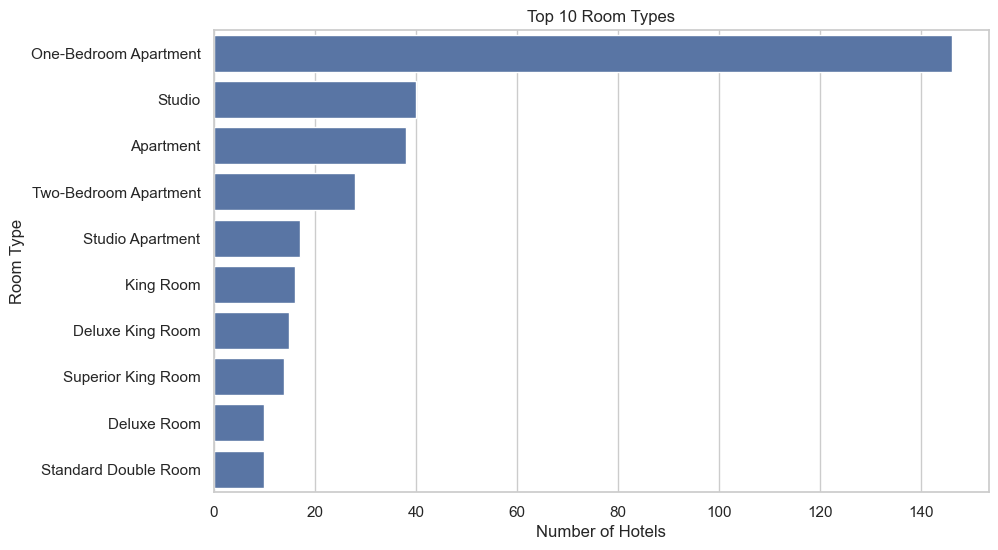

In [25]:
room_counts = df['RoomType'].value_counts().head(10)
sns.barplot(x=room_counts.values, y=room_counts.index)
plt.title("Top 10 Room Types")
plt.xlabel("Number of Hotels")
plt.ylabel("Room Type")
plt.show()

## Predictive Modeling
### Linear Regression

In [28]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# Select features and target
features = df[['RoomCategory', 'LocationGroup', 'DistanceFromCenter', 'RatingBucket', 'DiscountBucket', 'OriginalPrice']]
target = df['PricePerNight']

# Save the column names to use during prediction
joblib.dump(features.columns, 'model_columns.pkl')

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Build and Train the Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test data
y_pred = lr_model.predict(X_test)

# Model Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the values
print("📊 Linear Regression Performance:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

📊 Linear Regression Performance:
RMSE: 33.58
MAE: 16.65
R² Score: 0.98


### Random Forest Regressor

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Build and train Random Forest Regressor Model
rf_model = RandomForestRegressor(n_estimators=300, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test)

# Model Evaluation
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print the values
print("📊 Random Forest Regressor Performance:")
print(f"RMSE: {rmse_rf:.2f}")
print(f"MAE: {mae_rf:.2f}")
print(f"R² Score: {r2_rf:.2f}")

📊 Random Forest Regressor Performance:
RMSE: 24.81
MAE: 7.98
R² Score: 0.99


## Visualizing the Predictions

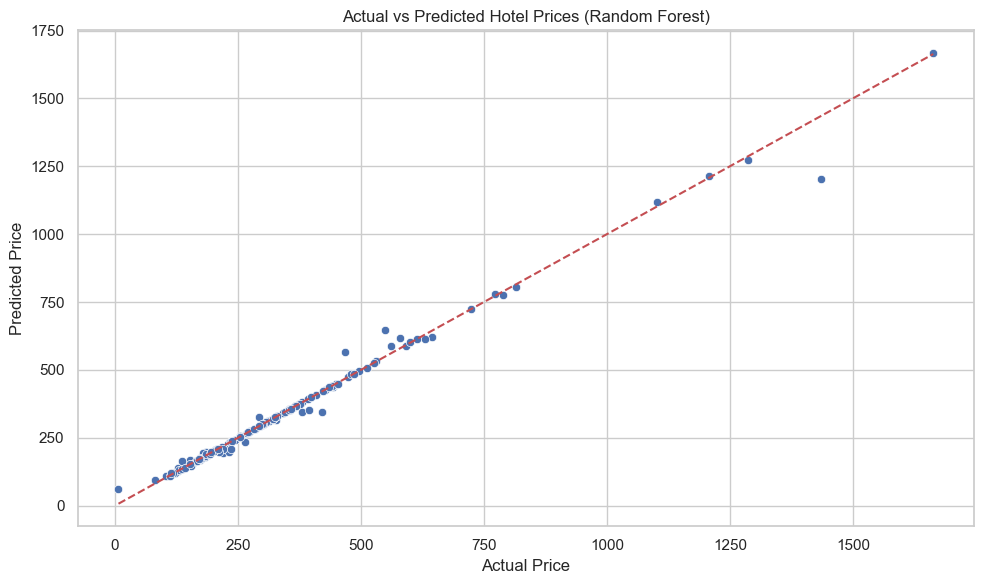

In [32]:
# Compare Actual vs Predicted
sns.scatterplot(x=y_test, y=y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal line
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Hotel Prices (Random Forest)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
import joblib
joblib.dump(rf_model, 'hotel_price_predictor.pkl')

['hotel_price_predictor.pkl']